# Test de directivité dyadique entre l’espace des nombres premiers et l’espace des semiprimes

Ce notebook explore empiriquement la manière dont la position de deux nombres premiers `p` et `q`,
choisis dans un même palier dyadique, influence la localisation de leur produit `n = p × q`
dans un palier dyadique supérieur.

L’objectif n’est **ni algorithmique**, ni **cryptographique**, mais **géométrique** :
il s’agit de déterminer si l’espace des semiprimes hérite d’une structure orientée
(issue de l’espace des nombres premiers), une fois les grandeurs correctement normalisées.

L’approche repose sur :
- une normalisation dyadique stricte,
- un conditionnement par palier du produit,
- et une analyse visuelle et statistique de la distribution résultante.

In [15]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
# Primalité (rapide pour petits n)
def is_prime(n: int) -> bool:
    if n < 2:
        return False
    if n % 2 == 0:
        return n == 2
    r = int(math.isqrt(n))
    f = 3
    while f <= r:
        if n % f == 0:
            return False
        f += 2
    return True

In [12]:
def k_of(n: int) -> int:
    """
    Retourne le palier dyadique k tel que:
    2^(k-1) <= n < 2^k
    """
    if n <= 0:
        raise ValueError("n doit être un entier strictement positif")
    return n.bit_length()

In [10]:
# Palier dyadique + normalisation intra-palier
def dyadic_band(k: int):
    low = 1 << (k - 1)
    high = (1 << k) - 1
    return low, high

def u_in_band(x: int, k: int) -> float:
    low, _ = dyadic_band(k)
    return (x - low) / low  # dans [0,1)

## Choix du k de p et q ##

In [49]:
k = 15
low, high = dyadic_band(k)
pr = [x for x in range(low, high+1) if is_prime(x)]
len(pr), pr[:10], pr[-10:]

(1612,
 [16411, 16417, 16421, 16427, 16433, 16447, 16451, 16453, 16477, 16481],
 [32633, 32647, 32653, 32687, 32693, 32707, 32713, 32717, 32719, 32749])

## Principe de l’expérience

On fixe :
- un palier dyadique `k` pour les nombres premiers `p` et `q`,
- un palier dyadique `k_prod` pour le produit `n = p × q`.

Pour chaque couple `(p, q)` admissible (avec `p ≤ q`), on calcule :
- `u_p` : position normalisée de `p` dans son palier,
- `u_q` : position normalisée de `q` dans son palier,
- `u_n` : position normalisée de `n` dans le palier produit.

Les coordonnées `u_p`, `u_q`, `u_n` appartiennent toutes à l’intervalle `[0,1)`.

Cette normalisation permet de comparer **des structures géométriques indépendamment de l’échelle absolue**.


In [50]:
rows = []
for i, p in enumerate(pr):
    for q in pr[i:]:  # p<=q
        n = p*q
        kprod = k_of(n)
        rows.append({
            "p": p, "q": q, "n": n,
            "u_p": u_in_band(p, k),
            "u_q": u_in_band(q, k),
            "k_prod": kprod,
            "u_n": u_in_band(n, kprod),
        })

df = pd.DataFrame(rows)
df.head(), df.shape


(       p      q          n       u_p       u_q  k_prod       u_n
 0  16411  16411  269320921  0.001648  0.001648      29  0.003299
 1  16411  16417  269419387  0.001648  0.002014      29  0.003665
 2  16411  16421  269485031  0.001648  0.002258      29  0.003910
 3  16411  16427  269583497  0.001648  0.002625      29  0.004277
 4  16411  16433  269681963  0.001648  0.002991      29  0.004644,
 (1300078, 7))

In [51]:
Counter(df["k_prod"])

Counter({30: 784759, 29: 515319})

## A/ Premier test : “la localisation de n dépend-elle de p ?” (bandes verticales) ##
Pour chaque 𝑝, observons la distribution de 𝑢 𝑛.

In [52]:
k_target = 30  # choisis un palier produit à isoler (10,11,12 selon Counter)
sub = df[df["k_prod"] == k_target].copy()
sub.shape

(784759, 7)

In [53]:
# --- Contrôles de cohérence ---
print("u_n min / max :", sub["u_n"].min(), sub["u_n"].max())
print("u_p min / max :", sub["u_p"].min(), sub["u_p"].max())
print("u_q min / max :", sub["u_q"].min(), sub["u_q"].max())

assert sub["u_n"].between(0, 1, inclusive="left").all(), "u_n hors [0,1)"
assert sub["u_p"].between(0, 1, inclusive="left").all(), "u_p hors [0,1)"
assert sub["u_q"].between(0, 1, inclusive="left").all(), "u_q hors [0,1)"

# Vérifier que le palier produit est bien unique
assert sub["k_prod"].nunique() == 1, "Plusieurs k_prod dans sub"

u_n min / max : 3.557652235031128e-07 0.9976813364773989
u_p min / max : 0.00164794921875 0.99884033203125
u_q min / max : 0.41436767578125 0.99884033203125


## Question posée

La question centrale est la suivante :

> À palier produit fixé, la position de `n = p × q` dans son palier
> est-elle distribuée de manière uniforme,
> ou bien obéit-elle à une géométrie contrainte et orientée
> en fonction de la position de `p` et `q` dans leur palier ?

Autrement dit :
- observe-t-on un simple bruit combinatoire,
- ou l’émergence d’un **champ de directivité** entre l’espace des nombres premiers
  et l’espace des semiprimes ?

## Champ moyen conditionnel

Afin de dépasser les visualisations ponctuelles, on étudie le champ moyen :

\[
E[u_n \mid u_p, u_q]
\]

Ce champ représente la position moyenne du produit `n`
conditionnée par les positions relatives de `p` et `q`.

Deux cartes sont analysées conjointement :
- le **champ moyen** proprement dit,
- la **carte des effectifs** (nombre de couples par case).

La comparaison des deux permet de distinguer :
- les structures géométriques réelles,
- des artefacts liés à l’échantillonnage.

## Frontières théoriques de faisabilité

Pour un palier produit donné, les couples `(p, q)` admissibles sont contraints par :

\[
2^{k_{\text{prod}}-1} \le p × q < 2^{k_{\text{prod}}}
\]

Ce qui induit, pour chaque `p`, des bornes explicites sur `q` :

\[
q_{\min}(p) = \left\lceil \frac{2^{k_{\text{prod}}-1}}{p} \right\rceil,
\quad
q_{\max}(p) = \left\lfloor \frac{2^{k_{\text{prod}}}-1}{p} \right\rfloor
\]

Ces frontières sont tracées par-dessus la heatmap afin de vérifier
si la géométrie observée est **entièrement expliquée**
par la contrainte multiplicative dyadique.


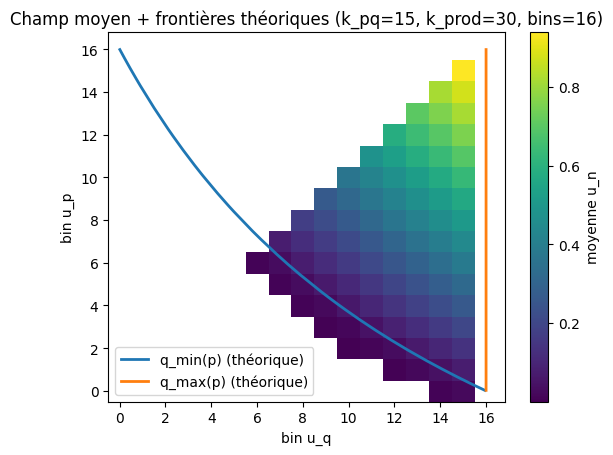

In [66]:
# Trace les frontières théoriques q_min(p), q_max(p) (en u) par-dessus la heatmap (u_p,u_q)
# À exécuter APRÈS avoir défini: k (palier de p,q), k_target (palier produit), B, df, sub, grid_mean, grid_cnt

import numpy as np
import matplotlib.pyplot as plt

# --- paramètres ---
k_pq = k                 # palier de p et q (ex: 15)
k_prod = k_target        # palier du produit (ex: 30)
B = B                    # nb de bins (ex: 16)

low_pq, high_pq = dyadic_band(k_pq)
L = 1 << (k_prod - 1)
U = (1 << k_prod) - 1

# On trace les frontières pour une gamme de p "réels" (entiers) dans la bande.
# Tu peux remplacer par sorted(sub["p"].unique()) si tu veux seulement les p premiers utilisés.
#ps = np.arange(low_pq, high_pq + 1, dtype=int)
ps = np.array(sorted(sub["p"].unique()), dtype=int)

def ceil_div(a, b):
    return (a + b - 1) // b

u_p_vals = np.array([u_in_band(int(p), k_pq) for p in ps], dtype=float)

qmin = np.array([ceil_div(L, int(p)) for p in ps], dtype=int)
qmax = np.array([U // int(p) for p in ps], dtype=int)

# On clippe dans la bande k_pq (sinon u_in_band n'a plus de sens "dans le palier")
qmin_clip = np.clip(qmin, low_pq, high_pq)
qmax_clip = np.clip(qmax, low_pq, high_pq)

u_qmin = np.array([u_in_band(int(q), k_pq) for q in qmin_clip], dtype=float)
u_qmax = np.array([u_in_band(int(q), k_pq) for q in qmax_clip], dtype=float)

# --- convertir en coordonnées de bins (axes bin u_p / bin u_q) ---
bin_u_p = u_p_vals * B
bin_u_qmin = u_qmin * B
bin_u_qmax = u_qmax * B

# --- afficher la heatmap + frontières ---
plt.figure()
plt.imshow(grid_mean, origin="lower", aspect="auto")
plt.title(f"Champ moyen + frontières théoriques (k_pq={k_pq}, k_prod={k_prod}, bins={B})")
plt.xlabel("bin u_q")
plt.ylabel("bin u_p")
plt.colorbar(label="moyenne u_n")

# frontières (en rouge)
plt.plot(bin_u_qmin, bin_u_p, linewidth=2, label="q_min(p) (théorique)")
plt.plot(bin_u_qmax, bin_u_p, linewidth=2, label="q_max(p) (théorique)")

plt.legend(loc="best")
plt.show()


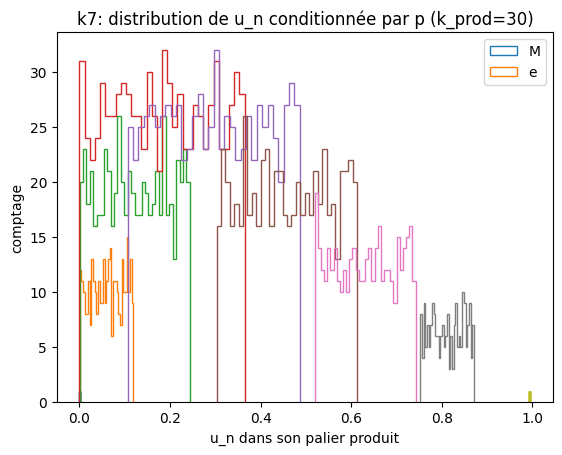

In [54]:
# Pour quelques p, histogrammes de u_n
ps = sorted(sub["p"].unique())
sample_ps = ps[::max(1, len(ps)//8)]  # ~8 valeurs

plt.figure()
for p in sample_ps:
    u = sub[sub["p"]==p]["u_n"].to_numpy()
    plt.hist(u, bins=32, histtype="step", label=str(p))
plt.title(f"k7: distribution de u_n conditionnée par p (k_prod={k_target})")
plt.xlabel("u_n dans son palier produit")
plt.ylabel("comptage")
plt.legend("Me")
plt.show()

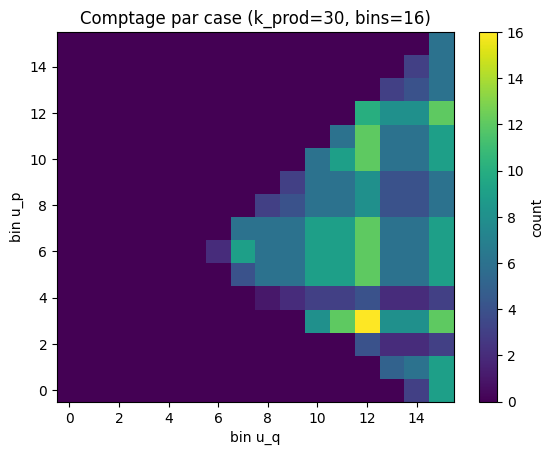

In [56]:
plt.figure()
plt.imshow(grid_cnt, origin="lower", aspect="auto")
plt.title(f"Comptage par case (k_prod={k_target}, bins={B})")
plt.xlabel("bin u_q")
plt.ylabel("bin u_p")
plt.colorbar(label="count")
plt.show()

## B — Test direct : corrélation 𝑢_𝑝 → 𝑢_𝑛 (directivité globale) ##

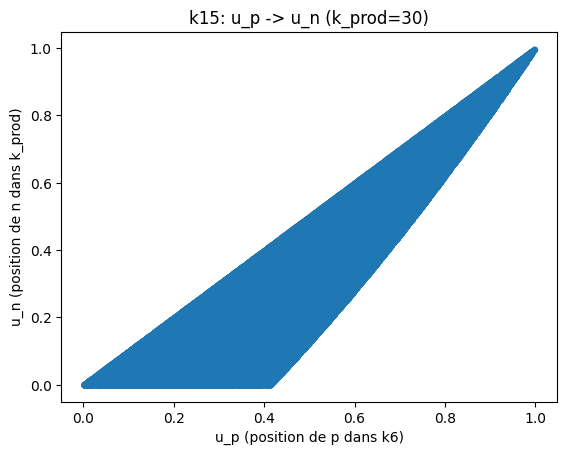

In [58]:
plt.figure()
plt.scatter(sub["u_p"], sub["u_n"], s=10, alpha=0.6)
plt.title(f"k15: u_p -> u_n (k_prod={k_target})")
plt.xlabel("u_p (position de p dans k6)")
plt.ylabel("u_n (position de n dans k_prod)")
plt.show()

## C — Test “champ 2D” : carte moyenne de 𝑢_𝑛 selon (𝑢_p, 𝑢_𝑞) ##
Ce test doit permettre de voir s'il y a une une logique de projection des produits de “l'espace des primes” → “l'espace des semiprimes”.

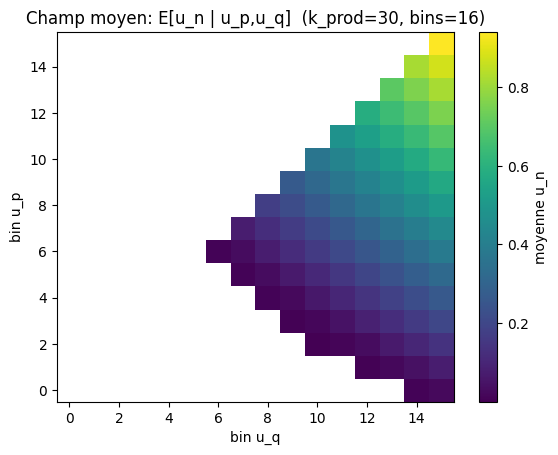

In [59]:
# Binning (u_p,u_q) -> moyenne u_n
B = 16
grid_sum = np.zeros((B,B))
grid_cnt = np.zeros((B,B))

up = sub["u_p"].to_numpy()
uq = sub["u_q"].to_numpy()
un = sub["u_n"].to_numpy()

ix = np.clip((up * B).astype(int), 0, B-1)
iy = np.clip((uq * B).astype(int), 0, B-1)

for a,b,val in zip(ix, iy, un):
    grid_sum[a,b] += val
    grid_cnt[a,b] += 1

grid_mean = np.divide(grid_sum, grid_cnt, out=np.full_like(grid_sum, np.nan), where=grid_cnt>0)

plt.figure()
plt.imshow(grid_mean, origin="lower", aspect="auto")
plt.title(f"Champ moyen: E[u_n | u_p,u_q]  (k_prod={k_target}, bins={B})")
plt.xlabel("bin u_q")
plt.ylabel("bin u_p")
plt.colorbar(label="moyenne u_n")
plt.show()


## Mesure synthétique : variance résiduelle

Pour quantifier le degré de déterminisme du champ observé,
on compare :

- la variance globale de `u_n`,
- la variance résiduelle après conditionnement par `(u_p, u_q)`.

Le rapport des deux fournit une mesure compacte du fait que :
- `u_n` est majoritairement déterminé par `(u_p, u_q)`,
- et non distribué de manière isotrope ou aléatoire.

Un ratio faible et stable à travers les échelles
indique l’existence d’un régime géométrique robuste.


In [60]:
global_var = np.nanvar(un)

# variance résiduelle par case
res = []
for a in range(B):
    for b in range(B):
        m = grid_mean[a,b]
        if not np.isnan(m):
            mask = (ix==a) & (iy==b)
            res.append(np.mean((un[mask] - m)**2))

residual_var = float(np.mean(res)) if res else np.nan
global_var, residual_var, residual_var/global_var


(np.float64(0.05273825671815842),
 0.0003938821728132416,
 np.float64(0.0074686232978501774))

## Conclusion

Ce test met en évidence que :

- la distribution des produits `n = p × q` dans un palier dyadique donné
  n’est pas isotrope ;
- elle est gouvernée par une géométrie de faisabilité déterministe,
  induite par la contrainte multiplicative dyadique ;
- les nombres premiers n’introduisent pas la forme globale,
  mais en modulent la texture et la granularité ;
- cette géométrie est stable lorsque l’on change d’échelle,
  une fois les grandeurs correctement normalisées.

L’espace des semiprimes apparaît ainsi comme un espace **orienté**,
héritant d’une structure géométrique issue de l’espace des nombres premiers.
